Initially we wish to setup the python environment, as such we import the required packages:

In [1]:

import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Before building the model we need the data first uaing the data pre-processing from the DATA notebook 

In [2]:
data = pd.read_csv('sunspots.txt', header=0)

data = data.set_index(['Month'])
data.index = pd.to_datetime(data.index)
if not data.index.is_monotonic:
    data = data.sort_index()


In [3]:
dataValues = data["Sunspots"]
dataValues = pd.to_numeric(dataValues)

dataMax = dataValues.max()
dataMin = dataValues.min()


In [4]:
dataNormalized = (dataValues - dataMin) / (dataMax - dataMin)

In [5]:
def lagged_time_series(TS,nlag):
    
    dataCopy = TS.copy()
    
    for n in range(1,nlag+1):
        
        dataCopy[f"lag{n}"] = dataCopy["Sunspots"].shift(n)
        
    dataCopy = dataCopy.iloc[nlag:]
    
    return dataCopy

lag = 6
dataLagged = lagged_time_series(data,lag)

# dataLagged
# dataLagged.shape
 
Y = dataLagged[["Sunspots"]]
    
X = dataLagged.drop(columns=["Sunspots"])


# TRAIN AND REMAIN SPLIT
Split1 = int(len(Y)*0.8)

Xtrain, Xremain = X[:Split1],X[Split1:]
Ytrain, Yremain = Y[:Split1],Y[Split1:]
              
# TEST AND VAL SPLIT
Split2 = int(len(Yremain)*0.5)

Xtest, Xval = Xremain[:Split2],Xremain[Split2:]
Ytest, Yval = Yremain[:Split2],Yremain[Split2:]


In [6]:
batchSize = 32

#Firstly it is required to convert the panda dataframes into Torch Tensor data structures:

TrainFeatures = torch.Tensor(np.array(Xtrain))
TrainTargets = torch.Tensor(np.array(Ytrain))

TrainSet = TensorDataset(TrainFeatures, TrainTargets)


ValFeatures = torch.Tensor(np.array(Xval))
ValTargets = torch.Tensor(np.array(Yval))

ValSet = TensorDataset(ValFeatures, ValTargets)


TestFeatures = torch.Tensor(np.array(Xtest))
TestTargets = torch.Tensor(np.array(Ytest))

TestSet = TensorDataset(TestFeatures, TestTargets)


#Dataloaders
TrainLoader = DataLoader(TrainSet, batch_size=batchSize, shuffle=False, drop_last=True)

ValLoader = DataLoader(ValSet, batch_size=batchSize, shuffle=False, drop_last=True)

TestLoader = DataLoader(TestSet, batch_size=batchSize, shuffle=False, drop_last=True)

Loader_one = DataLoader(TestSet, batch_size=1, shuffle=False, drop_last=True)

Having read in all the data we proceed to build the model. Firslt we'll check whether these is a GPU available to use in training the model.

In [7]:
# First checking if GPU is available
GPUpossible=torch.cuda.is_available()

if(GPUpossible):
    print('GPU available for training')
else:
    print('GPU not available for training')

GPU available for training


Having done the GPU initialization we will define a model:

In [8]:
class PureRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_dim, layer_dim, dropoutProb):
        super(PureRNN, self).__init__()

        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim

        #create layers

        self.rnn = nn.RNN(input_size, hidden_dim, layer_dim, batch_first=True, dropout=dropoutProb)
        
        self.tanh = nn.Tanh()
        
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):

        # Use 0 - initialzation for the hidden state:
        tempBatchSize = x.size(0)

        device = "cuda" if GPUpossible else "cpu"

        h0 = torch.zeros(self.layer_dim, tempBatchSize, self.hidden_dim).requires_grad_()
        h0 = h0.to(device)

        r_out, h0 = self.rnn(x, h0.detach())
        
        #apply Tanh activations
        r_out = self.tanh(r_out)
        
        # but need to ensure output dimensions are valid
        r_out = r_out[:, -1, :]
        
        
        
        output = self.fc(r_out)

        return output

In [9]:
# brief section just to see if it runs.
# testrnn = PureRNN(input_size = 1, output_size = 1, hidden_dim = 10, num_layers = 2,dropoutProb = 0.2)

# time_steps = np.linspace(0, np.pi, 100)
# data2 = np.sin(time_steps)
# data2.resize((100, 1))

# test_input = torch.Tensor(data2).unsqueeze(0) # give it a batch_size
# test_out, test_h = testrnn(test_input, None)
# print('Output size: ', test_out.size())
# print('Hidden state size: ', test_h.size())

With the foundation of the model laid out, we need to specify the Objective functions, training loops and evaluation loops first. Using the programming principles as laid out by Object Oriented Programming we will construct a helper class which contains these methods. Hence we create an Optimization class which houses a model, its Objective Function and optimization strategy. It then iteratively trains it via trainIter (a single step) subject to a gradient clipping factor of 3, this also returns the loss incurred for the step. It also houses the train method which trains the model via minibatches; as well as the evaluate method which determined the validation error of the model. Lastly it houses a rudementary plotting function

In [10]:
class Optimization:
    # instantiate self parameters- constructor
    def __init__(self, model, loss_fn, optimizer, gradClip = 3):

        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer

        self.TrainLosses = []
        self.ValLosses = []

    # Create Train method
    def trainIter(self, X, Y, gradClip = 3):
        # Determine whether GPU acceleration features available
        if (GPUpossible):
            self.model.cuda()

        # Set model to train mode
        self.model.train()

        # Generate output (i.e forward pass)
        pred = self.model(X)

        # Calculate Loss
        loss = self.loss_fn(Y, pred)

        # Perform BackPropagation
        loss.backward()

        # Update parameters via optimizer , note gradient clipping first
        nn.utils.clip_grad_norm_(self.model.parameters(), gradClip)
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # Model Training
    def train(self , TrainLoader, ValLoader, batchSize=32, numEpochs=100, featuresDim = 1):


            # cast to GPU is possible
            device = "cuda" if GPUpossible else "cpu"
            
            # loop through the batches
            for epoch in range(1, numEpochs + 1):

                batchLosses = []

                for x_batch, y_batch in TrainLoader:

                    x_batch = x_batch.view([batchSize, -1, featuresDim]).to(device)

                    y_batch = y_batch.to(device)

                    loss = self.trainIter(x_batch, y_batch)

                    batchLosses.append(loss)

                trainingLoss = np.mean(batchLosses)

                self.TrainLosses.append(trainingLoss)

                with torch.no_grad():

                    batchValLosses = []

                    for x_val, y_val in ValLoader:

                        x_val = x_val.view([batchSize, -1, featuresDim]).to(device)

                        y_val = y_val.to(device)

                        self.model.eval()

                        pred = self.model(x_val)

                        val_loss = self.loss_fn(y_val, pred).item()

                        batchValLosses.append(val_loss)

                    validationLoss = np.mean(batchValLosses)

                    self.ValLosses.append(validationLoss)

                if (epoch <= 10) | (epoch % 50 == 0):
                    print(
                        f"[{epoch}/{numEpochs}] Training loss: {trainingLoss:.4f}\t Validation loss: {validationLoss:.4f}"
                    )

    # Validation Analysis
    def evaluate(self, TestLoader, batchSize=1, featuresDim=1):

        device = "cuda" if GPUpossible else "cpu"
        # device = "cpu"

        with torch.no_grad():

            predictions = []
            values = []

            for x_test, y_test in TestLoader:

                x_test = x_test.view([batchSize, -1, featuresDim]).to(device)

                y_test = y_test.to(device)

                self.model.eval()

                pred = self.model(x_test)

                predictions.append(pred.to(device).detach().cpu().numpy())

                values.append(y_test.to(device).detach().cpu().numpy())

        return predictions, values


    def plot_losses(self):
        plt.plot(self.TrainLosses, label="Training Error")
        plt.plot(self.ValLosses, label="Validation Error")
        plt.legend()
        plt.title("A line graph showing the error over epochs")
        plt.show()
        plt.close()

Having defined a model Optimization class which allows for the training and evaluating of the model we may finally train the model.
Firstly we set the dimensions of the model, then we create a model RNN and train and evaluate it using the helper class Optimization

In [11]:

inputDim = len(Xtrain.columns)
outputDim = 1
hiddenDim = 64
nLayers = 3
batchsize = batchSize
dropout = 0.4
nEpochs = 2000
LR = 1e-3
WD = 1e-4


[1/2000] Training loss: 3064.4321	 Validation loss: 6041.0677
[2/2000] Training loss: 2740.0353	 Validation loss: 5671.5272
[3/2000] Training loss: 2524.4478	 Validation loss: 5341.2014
[4/2000] Training loss: 2340.8607	 Validation loss: 5052.1179
[5/2000] Training loss: 2189.4620	 Validation loss: 4812.9325
[6/2000] Training loss: 2059.7796	 Validation loss: 4601.2452
[7/2000] Training loss: 1952.3579	 Validation loss: 4427.3066
[8/2000] Training loss: 1857.4132	 Validation loss: 4253.0951
[9/2000] Training loss: 1759.8707	 Validation loss: 4097.6929
[10/2000] Training loss: 1687.0973	 Validation loss: 3965.7685
[50/2000] Training loss: 656.5621	 Validation loss: 1714.6904
[100/2000] Training loss: 473.7533	 Validation loss: 1086.4066
[150/2000] Training loss: 439.1506	 Validation loss: 805.6626
[200/2000] Training loss: 368.7192	 Validation loss: 705.4305
[250/2000] Training loss: 385.7983	 Validation loss: 745.4520
[300/2000] Training loss: 356.3525	 Validation loss: 676.0331
[350/2

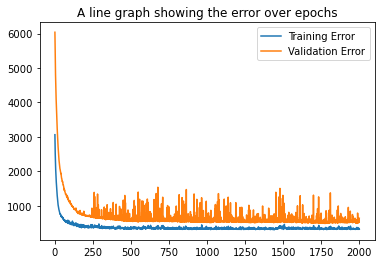

In [12]:
RNN = PureRNN(input_size = inputDim, output_size = outputDim, hidden_dim = hiddenDim, layer_dim = nLayers, dropoutProb = dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN.parameters(), lr=LR, weight_decay=WD)

opt = Optimization(model=RNN, loss_fn = criterion, optimizer = optimizer)
opt.train(TrainLoader, ValLoader, batchSize = batchsize, numEpochs=nEpochs, featuresDim = inputDim)
opt.plot_losses()

predictions, values = opt.evaluate(Loader_one, batchSize = 1, featuresDim = inputDim)

Thus we see that the lowest Validation error occurs around 500 epochs afterwhich the Validation error starts to rise and behave far more sporadically, hence we implement a early stopping routine 1 (see appendix) and redefine the model and retrain it till this point.

[1/500] Training loss: 3049.9329	 Validation loss: 6010.4155
[2/500] Training loss: 2722.1479	 Validation loss: 5645.5110
[3/500] Training loss: 2510.3815	 Validation loss: 5322.0142
[4/500] Training loss: 2335.1330	 Validation loss: 5047.8980
[5/500] Training loss: 2185.0130	 Validation loss: 4809.6295
[6/500] Training loss: 2058.7074	 Validation loss: 4602.9558
[7/500] Training loss: 1946.9219	 Validation loss: 4409.9613
[8/500] Training loss: 1848.0199	 Validation loss: 4235.2072
[9/500] Training loss: 1756.5329	 Validation loss: 4066.7626
[10/500] Training loss: 1667.4874	 Validation loss: 3914.4472
[50/500] Training loss: 658.5368	 Validation loss: 1695.2767
[100/500] Training loss: 479.5993	 Validation loss: 1050.2244
[150/500] Training loss: 450.3757	 Validation loss: 943.1018
[200/500] Training loss: 390.3343	 Validation loss: 709.2085
[250/500] Training loss: 366.6048	 Validation loss: 671.2295
[300/500] Training loss: 335.8412	 Validation loss: 645.7450
[350/500] Training los

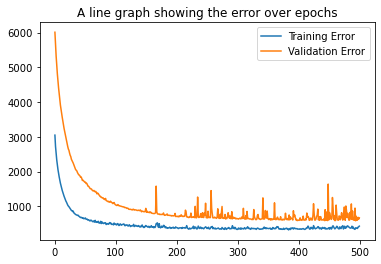

In [18]:
RNN = None

nEpochs = 500

RNN = PureRNN(input_size = inputDim, output_size = outputDim, hidden_dim = hiddenDim, layer_dim = nLayers, dropoutProb = dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(RNN.parameters(), lr=LR, weight_decay=WD)

opt = Optimization(model=RNN, loss_fn = criterion, optimizer = optimizer)
opt.train(TrainLoader, ValLoader, batchSize = batchsize, numEpochs=nEpochs, featuresDim = inputDim)
opt.plot_losses()

predictions, values = opt.evaluate(Loader_one, batchSize = 1, featuresDim = inputDim)

Using this new model we can now perform some predictions using the testing data instead, this is done in the evaluation method, however note once done some preliminart data manipulation needs to be done in order to get it into the correct format. We also calculate the test error as defined in the Appendix to be the expexted value of the cost over an independent dataset.

In [14]:
    Targets = np.concatenate(values, axis=0).ravel()
    Preds = np.concatenate(predictions, axis=0).ravel()
    Results = pd.DataFrame(data={"Value": Targets, "Prediction": Preds}, index=Xtest.head(len(Targets)).index)
    Results = Results.sort_index()
    
    Results

,Value,Prediction
Month,,
1937-02-01,128.500000,100.819595
1937-03-01,83.900002,101.065819
1937-04-01,109.300003,88.960983
1937-05-01,116.699997,100.861023
1937-06-01,130.300003,100.051262
...,...,...
1960-02-01,106.000000,101.216133
1960-03-01,102.199997,98.870590
1960-04-01,122.000000,100.437851


In [15]:
TestError = ((Targets - Preds)**2).mean(axis=None)

TestError

1528.6564

This can then get plotted out:

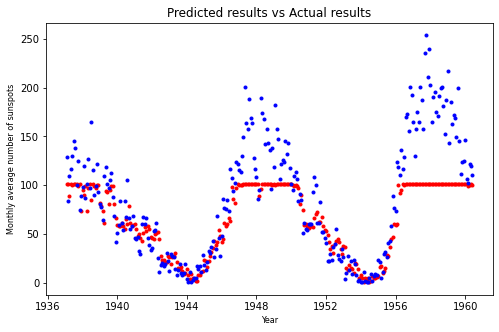

In [16]:
plt.figure(figsize=(8, 5))

plt.plot(Results["Prediction"], 'r.')
plt.plot(Results["Value"], 'b.')

plt.title("Predicted results vs Actual results")
plt.xlabel('Year', fontsize=8)

plt.ylabel('Monthly average number of sunspots', fontsize=8)

plt.show()



Hence we see that although the model isn't perfect it does capture the general trend sufficiently well. As a final note, the model state dictionary can be displayed

In [17]:
print("Model's state_dict:")
for param_tensor in RNN.state_dict():
    print(param_tensor, "\t", RNN.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
rnn.weight_ih_l0 	 torch.Size([64, 6])
rnn.weight_hh_l0 	 torch.Size([64, 64])
rnn.bias_ih_l0 	 torch.Size([64])
rnn.bias_hh_l0 	 torch.Size([64])
rnn.weight_ih_l1 	 torch.Size([64, 64])
rnn.weight_hh_l1 	 torch.Size([64, 64])
rnn.bias_ih_l1 	 torch.Size([64])
rnn.bias_hh_l1 	 torch.Size([64])
rnn.weight_ih_l2 	 torch.Size([64, 64])
rnn.weight_hh_l2 	 torch.Size([64, 64])
rnn.bias_ih_l2 	 torch.Size([64])
rnn.bias_hh_l2 	 torch.Size([64])
fc.weight 	 torch.Size([1, 64])
fc.bias 	 torch.Size([1])
Optimizer's state_dict:
state 	 {0: {'step': 28000, 'exp_avg': tensor([[-3.2595e-02, -4.6832e-02, -4.3502e-02, -6.5845e-02, -6.7941e-02,
         -7.7155e-02],
        [-9.0870e-04, -7.4041e-04, -1.0199e-03,  5.3229e-05, -4.1590e-05,
         -4.2338e-04],
        [ 9.7155e-03,  6.7606e-03,  5.7761e-03,  2.4458e-03,  6.3693e-03,
          6.0921e-03],
        [ 8.8892e-03,  1.2231e-02,  1.2635e-02,  1.3394e-02,  1.5512e-02,
          1.4020e-02],
        [ 1.9064e-02,  4.226